## Vision Systems in Agriculture (Part 2)

### Section 1: Understanding basics of PyTorch

PyTorch is a machine/deep learning framework based on the Torch library. It was developed by Meta AI and has broad application in computer vision and natural language processing.

[PyTorch website](https://pytorch.org/)

[60-minute tutorial on Deep Learning with PyTorch](https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html): Please go over this in your spare time.

### Section 2: Image object detection using a pretrained model

Steps to take:
1. Find an existing performant model trained on dataset same as your target dataset
2. Initialize the model and pretrained model weights
3. Preprocess the image to fit the input requirements of the model
4. Make the prediction
5. Analyze the prediction results
6. Visualize the prediction results
7. Evaluate the results

---

0. Install PyTorch library

In [2]:
# In your python virtual environment, run the commands
pip install torch torchvision

SyntaxError: invalid syntax (2588694200.py, line 2)

1. Find an existing performant model trained on dataset same as your target dataset

Looking over the [PyTorch model list](https://pytorch.org/vision/stable/models.html#table-of-all-available-classification-weights), we select the [MaskRCNN model with the ResNet-50-FCN](https://pytorch.org/vision/stable/models/generated/torchvision.models.detection.maskrcnn_resnet50_fpn.html#torchvision.models.detection.MaskRCNN_ResNet50_FPN_Weights)

2. Initialize the model and pretrained model weights

We are using [COCO dataset](https://cocodataset.org/#explore): Microsoft Common Objects in Context dataset is a large-scale object detection, segmentation, key-point detection, and captioning dataset. The dataset consists of 328K images. 

In [7]:
import torch
from torchvision.models.detection import maskrcnn_resnet50_fpn, MaskRCNN_ResNet50_FPN_Weights

# 1. obtain and process weights
weights = MaskRCNN_ResNet50_FPN_Weights.COCO_V1
transforms = weights.transforms()

# 2. initialize the model
model = maskrcnn_resnet50_fpn(weights=weights, progress=False)
model = model.eval()

# 3. explore the model details
print(model)

# 4. TODO: Get the categories (class labels) from the metadata. See if you can identify all the fruit/vegetables categories
categories = weights.meta["categories"]
print(categories)

# apples, banana, orange, broccoli, carrot, 



MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(in

2. Import target image

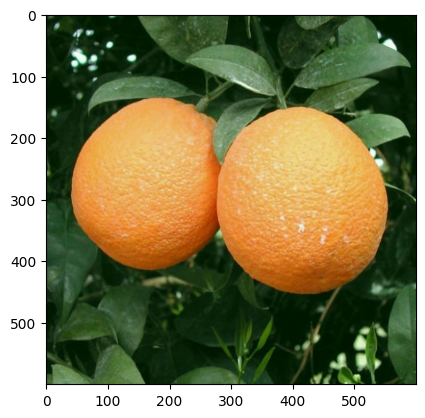

In [8]:
from PIL import Image
import matplotlib.pyplot as plt


# 1. load the image 
image_path = './img/orange.jpg'
image = Image.open(image_path).convert("RGB")

# 2. display the image
plt.imshow(image)


3. Preprocess the image to fit the input requirements of the model

In [9]:
import torchvision.transforms as T

# convert to a tensor and normalizes the data as well as shape of the image
preprocess = T.Compose([
    T.ToTensor(),
])

img_preprocess = preprocess(image).unsqueeze(0)


# TODO: Explore the shape/size of both input image and the preprocessed version
print(f'Shape of original image: {image.size}')
print(f'Shape of pre-processed image: {img_preprocess.shape}')
print(f'Size of pre-processed image: {img_preprocess.size}')

Shape of original image: (600, 600)
Shape of pre-processed image: torch.Size([1, 3, 600, 600])
Size of pre-processed image: <built-in method size of Tensor object at 0x7f6138ed3bf0>


4. Perform model prediction

In [10]:
# make a prediction
with torch.no_grad():
    predictions = model(img_preprocess)

5. Analyze prediction results

In [11]:
# Extract boxes, labels, scores, and masks from predictions
boxes = predictions[0]['boxes'].cpu().detach().numpy()
labels = predictions[0]['labels'].cpu().detach().numpy()
scores = predictions[0]['scores'].cpu().detach().numpy()
masks = predictions[0]['masks'].cpu().detach().numpy()


# TODO: Explore the prediction results. Notice the prediction scores
for i in range(len(scores)):
    print(f'Prediction {i+1}')
    print('--------------------------')
    print(f'Label: {categories[labels[i]]}')
    print(f'Score: {scores[i]}')
    print(f'Bbox: {boxes[i]}')
    print('\n')


Prediction 1
--------------------------
Label: orange
Score: 0.9941943287849426
Bbox: [ 42.328983 131.7653   292.7433   417.18628 ]


Prediction 2
--------------------------
Label: orange
Score: 0.9901257753372192
Bbox: [269.3617  147.77539 556.03577 460.36163]


Prediction 3
--------------------------
Label: orange
Score: 0.41960957646369934
Bbox: [ 52.97484 115.11862 541.2335  458.98932]




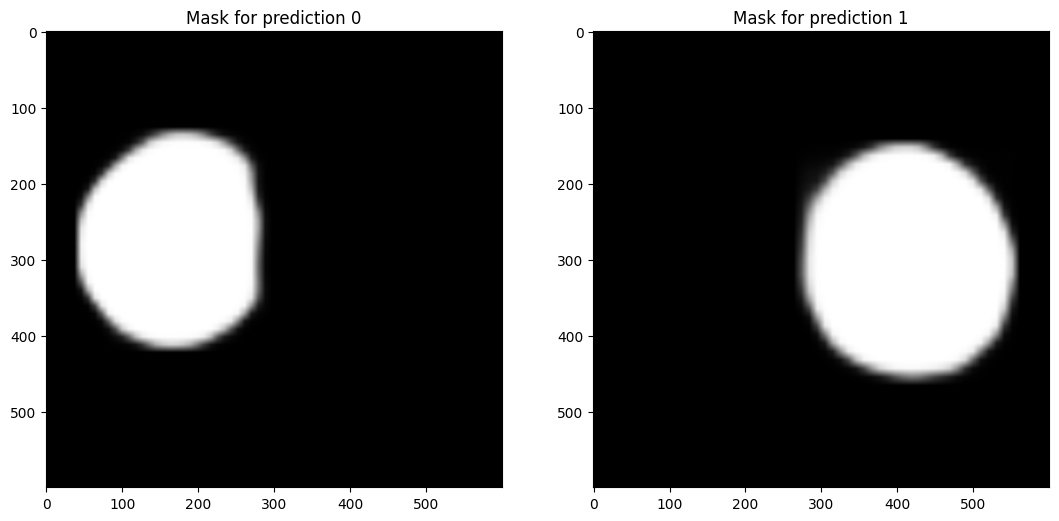

In [12]:
# TODO: Explore the masks for each prediction
score_threshold = 0.5
plt.figure(figsize=(20, 10))
for i in range(len(masks)):
    if scores[i] > score_threshold:
        plt.subplot(1, len(masks),i+1)
        plt.imshow(masks[i][0], cmap='gray')
        plt.title(f'Mask for prediction {i}')

Visualize results

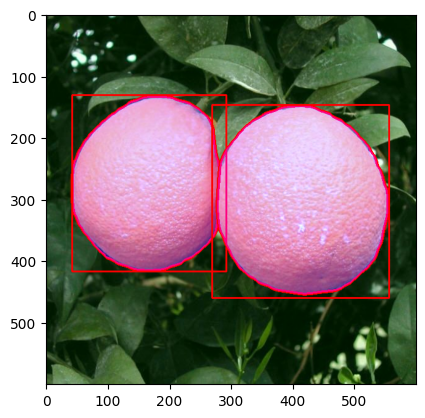

In [41]:
import cv2 as cv
import numpy as np

# TODO: Import the image using cv.imread 

img = cv.imread(image_path)
img = cv.cvtColor(img, cv.COLOR_BGR2RGB)

highlighted_img = img

# TODO: Using the threshold to filter predictions, apply the equivalent mask and draw the bounding box (using cv.rectangle()) on the image

for i in range(len(scores)):
    if scores[i] > score_threshold:
        mask = masks[i][0] > 0.5
        mask = (mask * 255).astype(np.uint8)
        bbox = boxes[i]
        bbox = [int(i) for i in bbox]

        contours, _ = cv.findContours(mask, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_NONE)
        bounding = cv.drawContours(highlighted_img, contours, -1, (255, 0, 0), 3)
       
        highlighted_mask = np.zeros_like(img)
        highlighted_mask[:, :, 2] = mask  # Assign mask to green channel for highlighting
        
        highlighted_img = cv.bitwise_and(highlighted_img, bounding)
        highlighted_img = cv.addWeighted(highlighted_img, 1, highlighted_mask, 0.5, 0)
        cv.rectangle(highlighted_img, (bbox[0], bbox[1]), (bbox[2], bbox[3]), (255, 0, 0), 2)

plt.imshow(highlighted_img)

# TODO: Plot the original image and the segmentation/bounding box image


Evaluate results

[array([ 42.328983, 131.7653  , 292.7433  , 417.18628 ], dtype=float32)]
[array([ 42.328983, 131.7653  , 292.7433  , 417.18628 ], dtype=float32), array([269.3617 , 147.77539, 556.03577, 460.36163], dtype=float32)]
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
ground_truths = [[41.0, 137.0, 554.0, 454.0]]
predictions = [array([ 42.328983, 131.7653  , 292.7433  , 417.18628 ], dtype=float32), array([269.3617 , 147.77539, 556.03577, 460.36163], dtype=float32)]


Text(0.5, 1.0, 'Ground truth vs predicted Bbox')

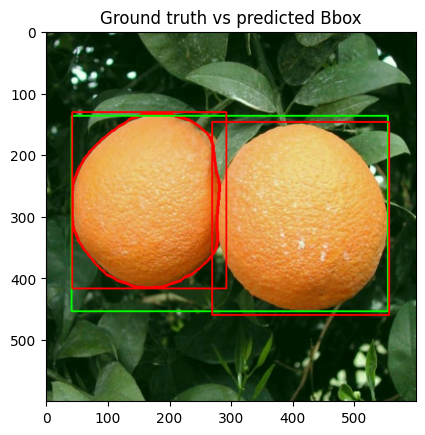

In [46]:
from helpers import get_ground_truth_ann, calculate_map

# Our goal here is to evaluate the segmentation and object detection prediction against ground truth data for the image

# TODO: Extract the bounding box information from the prediction result above and place into the prediction_bbox variable. Define a score threshold to use

prediction_bbox = []

for i in range(len(scores)):
    if scores[i] > score_threshold:

        prediction_bbox.append(boxes[i])
        print(prediction_bbox)



# Here we have provided a helper function to extract the ground truth bbox for the images
image_name = 'orange'
ground_truth_bbox = get_ground_truth_ann(image_name=image_name, show=False)

print(f'ground_truths = {ground_truth_bbox}')
print(f'predictions = {prediction_bbox}')


# TODO: plot the results
img_bbox = img.copy()

for gt in ground_truth_bbox:
    gt = [int(v) for v in gt]
    cv.rectangle(img_bbox, (gt[0], gt[1]), (gt[2], gt[3]), (0, 255, 0), 2)

for pd in prediction_bbox:
    pd = [int(v) for v in pd]
    cv.rectangle(img_bbox, (pd[0], pd[1]), (pd[2], pd[3]), (255, 0, 0), 2)


plt.imshow(img_bbox)
plt.title("Ground truth vs predicted Bbox")

In [48]:
# TODO: Use the calculate_map helper function to calculate the average precision of your object detection pipeline
mAP = calculate_map(ground_truth_bbox, prediction_bbox, iou_threshold=0.7)
print(mAP)

iou_max = 0.42905306816101074
precisions = [0.0], recalls = [0.0]
iou_max = 0.5289400219917297
precisions = [0.0, 0.0], recalls = [0.0, 0.0]
0.0


#### Additional exploration

Now you have walked though the process using the images we analyzed in the last class, we will run through the pipeline using another image with multiple fruit/vegetables.

Your task is to get an image online with fruits (e.g., apple, banana, orange) and run it through the object detection model and visualize the result.

One thing to do is to adjust the color of the visualization to match different fruit.

See example solution below.

<img src=".\img\solution3.png" width="800">

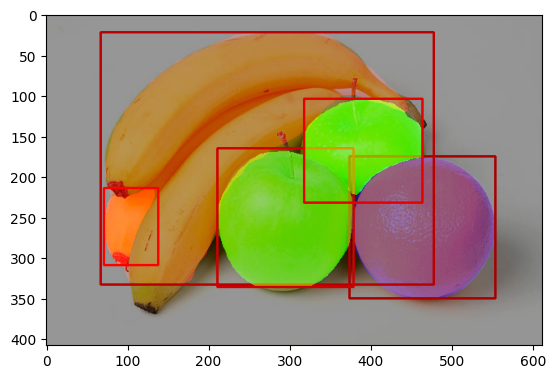

In [71]:
# load image
image_path = './img/fruits.jpg'
image = Image.open(image_path).convert("RGB")

# convert to a tensor and normalizes the data as well as shape of the image
preprocess = T.Compose([
    T.ToTensor(),
])

img_preprocess = preprocess(image).unsqueeze(0)

# make a prediction
with torch.no_grad():
    predictions = model(img_preprocess)

# Extract boxes, labels, scores, and masks from predictions
boxes = predictions[0]['boxes'].cpu().detach().numpy()
labels = predictions[0]['labels'].cpu().detach().numpy()
scores = predictions[0]['scores'].cpu().detach().numpy()
masks = predictions[0]['masks'].cpu().detach().numpy()

# Print prediction results
# for i in range(len(scores)):
#     print(f'Prediction {i+1}')
#     print('--------------------------')
#     print(f'Label: {categories[labels[i]]}')
#     print(f'Score: {scores[i]}')
#     print(f'Bbox: {boxes[i]}')
#     print('\n')

img = cv.imread(image_path)
img = cv.cvtColor(img, cv.COLOR_BGR2RGB)

highlighted_img = img

score_threshold = 0.7
# plt.figure(figsize=(20, 10))
# for i in range(len(masks)):
#     if scores[i] > score_threshold:
#         plt.subplot(1, len(masks),i+1)
#         plt.imshow(masks[i][0], cmap='gray')
#         plt.title(f'Mask for prediction {i}')

for i in range(len(scores)):
    if scores[i] > score_threshold:
        mask = masks[i][0] > 0.5
        mask = (mask * 255).astype(np.uint8)
        bbox = boxes[i]
        bbox = [int(i) for i in bbox]

        # contours, _ = cv.findContours(mask, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_NONE)
        # bounding = cv.drawContours(highlighted_img, contours, -1, (255, 0, 0), 3)

        color = ['banana', 'apple', 'orange']
        highlighted_mask = np.zeros_like(img)
        highlighted_mask[:, :, color.index(categories[labels[i]])] = mask
        
        # highlighted_img = cv.bitwise_and(highlighted_img, bounding)
        # highlighted_img = cv.bitwise_and(highlighted_img, highlighted_mask)
        highlighted_img = cv.addWeighted(highlighted_img, 0.9, highlighted_mask, 0.7, 0)
        cv.rectangle(highlighted_img, (bbox[0], bbox[1]), (bbox[2], bbox[3]), (255, 0, 0), 2)

plt.imshow(highlighted_img)